Model 1: Transfer-learning

In [ ]:
# import os
# import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.image import imread
# import cv2
# from plotly import express as px
# import plotly.io as pio
# import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

In [ ]:
# split the stanford_dogs data
(train_dataset, validation_dataset, test_dataset), metadata = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJNARVU/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJNARVU/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
# batch size
BATCH_SIZE = 32
# standard image size
IMG_SIZE = (299, 299)

In [ ]:
# Dog breeds number
num_classes = metadata.features['label'].num_classes
num_classes

120

In [ ]:
dog_labels= metadata.features['label'].int2str

In [ ]:
# resize images to a fixed image size(299 x 299)
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))

In [ ]:
# number of data to take each time 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=100)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=100)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=100)

In [ ]:
# normalize pixel values to [-1, 1]
i = tf.keras.Input(shape=(299, 299, 3))
x = tf.keras.applications.xception.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
# create a base model using xception
base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze the base_model
base_model.trainable = False


i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# create a model using Sequential
model1 = tf.keras.Sequential([
      # the preprocessor layer                        
      preprocessor,
      # augmentation layers 
      tf.keras.layers.RandomFlip("horizontal"),
      # augmentation layers 
      tf.keras.layers.RandomRotation(0.2),
      # The base model layer constructed above
      base_model_layer,
      # additional layer
      tf.keras.layers.GlobalAveragePooling2D(),
      # additional layers
      tf.keras.layers.Dropout(0.3),
      # A Dense(120) layer at the very end to actually perform the classification.
      tf.keras.layers.Dense(num_classes, activation="softmax") # number of classes
])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 299, 299, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 299, 299, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 299, 299, 3)      0         
 tation)                                                         
                                                                 
 model_1 (Functional)        (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)             

In [ ]:
# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_dataset,
                      epochs=10,
                      validation_data=validation_dataset)

Epoch 1/10
300/300 [==============================] - 182s 584ms/step - loss: 4.1432 - accuracy: 0.2639 - val_loss: 3.3669 - val_accuracy: 0.7475
Epoch 2/10
300/300 [==============================] - 175s 582ms/step - loss: 2.9592 - accuracy: 0.6433 - val_loss: 2.3012 - val_accuracy: 0.8508
Epoch 3/10
300/300 [==============================] - 175s 582ms/step - loss: 2.1583 - accuracy: 0.7312 - val_loss: 1.5983 - val_accuracy: 0.8758
Epoch 4/10
300/300 [==============================] - 175s 582ms/step - loss: 1.6500 - accuracy: 0.7614 - val_loss: 1.1709 - val_accuracy: 0.9025
Epoch 5/10
300/300 [==============================] - 174s 581ms/step - loss: 1.3522 - accuracy: 0.7783 - val_loss: 0.9140 - val_accuracy: 0.9075
Epoch 6/10
300/300 [==============================] - 175s 582ms/step - loss: 1.1619 - accuracy: 0.7864 - val_loss: 0.7520 - val_accuracy: 0.9100
Epoch 7/10
300/300 [==============================] - 175s 582ms/step - loss: 1.0374 - accuracy: 0.7955 - val_loss: 0.6448 -

In [ ]:
model1.evaluate(test_dataset)

38/38 [==============================] - 20s 502ms/step - loss: 0.4850 - accuracy: 0.9033


[0.48504796624183655, 0.903333306312561]

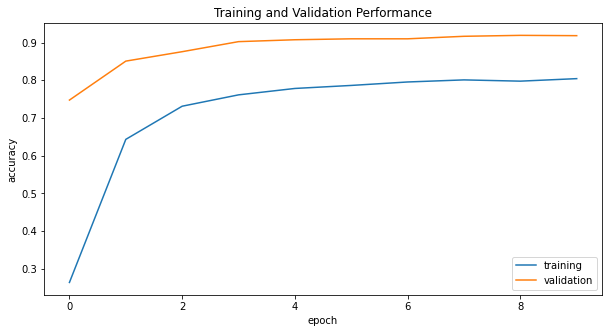

In [ ]:
# plot of accuracy
plt.figure(figsize=(10,5))
plt.plot(history1.history["accuracy"], label = "training")
plt.plot(history1.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.title("Training and Validation Performance")
plt.legend()

Fine-tune

In [ ]:
# https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
# unfreeze base model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


In [ ]:
model1.compile(loss='sparse_categorical_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 299, 299, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 299, 299, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 299, 299, 3)      0         
 tation)                                                         
                                                                 
 model_1 (Functional)        (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)             

In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model1.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history1.epoch[-1],
                          validation_data=validation_dataset)

Epoch 10/20
300/300 [==============================] - 257s 855ms/step - loss: 1.0634 - accuracy: 0.6780 - val_loss: 0.9068 - val_accuracy: 0.7133
Epoch 11/20
300/300 [==============================] - 252s 841ms/step - loss: 0.8818 - accuracy: 0.7266 - val_loss: 0.9127 - val_accuracy: 0.7300
Epoch 12/20
300/300 [==============================] - 253s 841ms/step - loss: 0.7649 - accuracy: 0.7613 - val_loss: 0.9866 - val_accuracy: 0.7208
Epoch 13/20
300/300 [==============================] - 253s 841ms/step - loss: 0.6981 - accuracy: 0.7799 - val_loss: 0.8073 - val_accuracy: 0.7508
Epoch 14/20
300/300 [==============================] - 252s 841ms/step - loss: 0.6287 - accuracy: 0.7959 - val_loss: 0.9870 - val_accuracy: 0.7250
Epoch 15/20
300/300 [==============================] - 253s 841ms/step - loss: 0.6077 - accuracy: 0.8071 - val_loss: 0.9046 - val_accuracy: 0.7408
Epoch 16/20
300/300 [==============================] - 252s 841ms/step - loss: 0.5440 - accuracy: 0.8313 - val_loss: 1

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Accuracy')

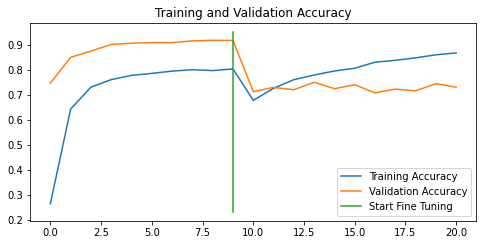

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
loss, accuracy = model1.evaluate(test_dataset)
print('Test accuracy :', accuracy)

38/38 [==============================] - 19s 498ms/step - loss: 1.1067 - accuracy: 0.7317
Test accuracy : 0.7316666841506958


[[0.00271759 0.0044816  0.00858912 0.01170013 0.00633639 0.00631447
  0.00610669 0.00668826 0.00812131 0.00626738 0.00573122 0.00598252
  0.00838291 0.00521398 0.00784113 0.00598774 0.00474903 0.00843737
  0.00867214 0.01053149 0.00949899 0.01001908 0.00815859 0.00964228
  0.01173799 0.00620845 0.00933856 0.00760279 0.00679823 0.00604985
  0.00826777 0.00466164 0.01843888 0.0096441  0.00664679 0.00823525
  0.01258796 0.00868185 0.0104663  0.00532786 0.00540189 0.00578437
  0.00955428 0.00691339 0.00424153 0.00923317 0.01171857 0.01410201
  0.00834215 0.00557079 0.00971276 0.00848665 0.006657   0.01041922
  0.00714636 0.00785442 0.0068556  0.00742115 0.00828635 0.0101449
  0.0089805  0.00702329 0.00779118 0.01328541 0.00925404 0.00543088
  0.00479896 0.00584631 0.00841803 0.00930228 0.01893606 0.00661046
  0.00969774 0.01152342 0.00469576 0.01381203 0.00594006 0.01519864
  0.00526641 0.00896986 0.00551732 0.00753172 0.03070932 0.00612185
  0.00924268 0.00735975 0.00377132 0.00616074 0.0

'n02106382-bouvier_des_flandres'

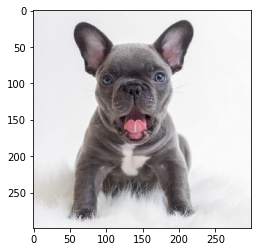

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np


classes = metadata.features['label'].names

img_width, img_height = 299, 299

# predicting images
img = image.load_img('/content/il_1588xN.2766222350_3tk8.jpg', target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)/255.

# Get predicted probabilities for 120 class labels
pred_classes = model1.predict(x, batch_size=32)
print(pred_classes)

# Display image being classified
plt.imshow(img)
get = np.argsort(pred_classes)
get=get[0]
print(get[-1:-6:-1])

# Get index of highest probability and use it to get class label
classes[np.argmax(pred_classes)]

In [ ]:
model1.save('/content/model1.h5')

# Model 1: Transfer Learning

We apply the transfer-learning method to our first model. The Stanford-dog dataset is from the TensorFlow database and will be our data. It contains 120 dog breeds around the world and 20580 images. Before we build our model, we standardize images' size to a size (299,299) and normalize pixel values to [-1, 1]. Setting batch size to 32 allows us to take 32 datasets from the training data and train it each time. For our base model, we use xception to create with excluding the top layers of the base model. In order not to update the weights of trained layers during training our data, we freeze them. We use the simplest way to make a model, which is `tf.keras.models.Sequential`. In the model, we apply preprocessor layer(standardize images' size and pixel values), augmentation layer(practice on copies of the same images), base model layer, GlobalAveragePooling2D layer, Dropout layer(reduce overfitting), and a Dense layer(to have 120 outputs). When we compile the model, we adjust optimizer and loss parameters. For optimizer, we use 'adam' and change the learning-rate value to 0.001. The reason why we replaced the default learning-rate value(e^-7) is smaller learning rate value will require more epochs for the model to learn and adapt. Addition, we use `tf.keras.losses.SparseCategoricalCrossentropy()` to calculate the loss due to this get a better accuracy on calculating it. When we train our data, we use 10 epochs because a bigger learning-rate value does not need many epochs to adapt. By looking at the training and validating accuracy on history, it's not overfitting and the validating accuracy is about 91%. And this is the highest score that we have got so far. The testing accuracy is 90%. Based on the result on accuracy, it seems well perform. 

To improve the performance, we unfreeze the base model and train the top layers. Then we need to retrain our data. One thing to notice is we have to use a really small learning-rate value to prevent overfitting, so we choose to use the default value which is e^-7. When we fit the model to the training data, we start from the last epoch number, and the model will do 10 epochs. Reviewing the result on the plot, the model starts overfitting after epoch 10. Taking the difference between training accuracy and validating accuracy, the maximum value is 13%. Even though, we still upload a French-bull-dog image and try to predict its breed with this model. Unfortunately, the result shows it's a Toy-poodle with the highest possibility. Moreover, the top 5 dog breeds do not include French-bull dog. We expected the model should have a better performance by giving a clear image with a single dog. Therefore, we want to try on a few more models and compare which one brings the best and most satisfying result.